## Part 6. Modern Geometric Prover
Wu’s method and Gröbner-basis proving are “old school algorithmic” in the best sense: once you translate a diagram into polynomial constraints, the prover can grind deterministically and still surprise you with what it manages to derive. That feels creative because the algorithm is not following a human narrative, yet it discovers nontrivial consequences reliably and at scale. The downside is exactly what you observed: these proofs often become long coordinate eliminations that certify truth, but don’t illuminate the geometry. In fact, modern surveys often summarize algebraic methods this way: extremely powerful decision procedures, but the output is typically not a readable, traditional geometry proof—more a yes/no outcome with an algebraic justification. [SURVEY]

A key idea that matured over the last two decades is to keep the computation, but move the “language of thought” closer to geometry itself. Semi-synthetic methods like the area method and the full-angle method do this by replacing raw coordinates with geometric invariants (directed areas, oriented angles, angle expressions) and carefully designed elimination rules. The area method is explicitly praised for producing proofs that are concise and human-readable while still being automated. [AREA]  The full-angle line of work went further by building rule systems around angle expressions in a way that can be structured hierarchically, which even enables visually dynamic, step-by-step presentations of proofs—much closer to how a person reasons with a diagram. [VDP]

This “human-facing” direction also pushed geometry provers into interactive and educational software. A milestone was the incorporation and testing of multiple automated geometry provers inside GeoGebra, motivated by the idea that automated deduction had become mature enough to change how people learn and explore geometry. [GGB]  Around the same time, community efforts like OpenGeoProver worked on unifying several proof styles (algebraic, semi-synthetic, synthetic) behind a common tool interface, so the user sees geometry objects while the backend can choose the best proving engine.

Then the last two years added a new ingredient that directly targets the “magic of auxiliary constructions”: systems that can propose new points/lines/circles in a human-like way. AlphaGeometry (Nature 2024) made this explicit: a neural language model guides a symbolic deduction engine through the huge branching factor of difficult Olympiad problems, and it reaches near gold-medalist performance on a benchmark of 30 problems. [AG1]  DeepMind’s own description highlights the core leap: the model predicts useful new constructs from an effectively infinite space, while the symbolic engine validates the consequences. [AG1-BLOG]  AlphaGeometry2 pushes this further by enriching the language and emphasizing auxiliary constructions even more strongly, and it is built on a more powerful Gemini-based model. [AG2]

What’s also interesting is that “auxiliary creativity” is no longer owned by neural models alone. HAGeo shows you can get gold-medal level performance by engineering strong heuristic auxiliary construction strategies wrapped around a symbolic deduction engine, running fully on CPUs without neural inference. [HAG]  GenesisGeo attacks the bottleneck from the other side: it open-sources a massive synthetic dataset (including millions of cases with auxiliaries) and accelerates the symbolic engine with C++ components, while also adding a neuro-symbolic prover based on Qwen3-0.6B-Base. [GEN]  These results collectively say something profound: the “human-like” part of geometry solving is largely about proposing the right extra objects, and we now have multiple competing ways to do that—LLMs, heuristics, and hybrid search.

Newclid is a nice example of how modern systems separate “frontend geometry” from “backend proof.” On the frontend, you describe the construction and goals (JGEX / GeoGebra import); in the backend, a symbolic engine (DDARN) runs deduction and proof search. The important architectural twist is that Newclid exposes an agent interface between them, so the choice of auxiliary construction strategy can be swapped: an LLM agent, a heuristic agent, a BFS-style agent, or even a human-in-the-loop agent. The Newclid paper explicitly frames its CLI as a way to run problems without a Python entry point and even to replace the original LLM with human decisions, while still using the same symbolic core. [NC]

Formal verification languages (Lean/Coq) matter because they make “correctness” non-negotiable. Once you have systems that generate highly non-obvious auxiliaries, you urgently need a small trusted kernel that can check every step. The area method already had a deep formalization path: Narboux implemented it as a decision procedure inside Coq, explicitly valuing short and readable proofs with machine-checkable elimination lemmas. [COQ-AM]  LeanGeo extends this spirit to competition-level geometry inside Lean 4, aiming for a unified, rigorously verified framework integrated with Mathlib and released with an open-source library and benchmark. [LG]  The big point is: “creative search” can be messy, probabilistic, and exploratory—but the final proof artifact can still be as clean and trustworthy as a textbook, because the checker is unforgiving.

Another piece of the “human-like” story is not just finding a proof, but presenting it in a way that looks like geometry again. Historically, this emerged as a reaction to coordinate/elimination proofs: Wu/Gröbner methods can certify truth, but the output often reads like algebraic elimination rather than geometric insight. Semi-synthetic provers helped because they operate in higher-level invariants (areas, oriented angles, angle expressions), which naturally map back into short Euclid-style steps that a student can follow. The full-angle method is a representative example: it was designed specifically so the proof object is a sequence of geometric statements that can be displayed and checked step by step, rather than a large polynomial certificate [FA].

Once the reasoning steps become “geometric sentences,” visualization becomes possible and valuable. A major milestone was the line of work on visually dynamic proof presentation, where the proof is organized hierarchically and the diagram is animated so that objects and relations appear exactly when the text uses them; this turns a proof from a static list of facts into a guided tour that matches human attention [VDP]. In parallel, automated provers began integrating into interactive geometry environments, so proving becomes part of exploration: you construct a figure, conjecture an invariant, and then ask the prover to justify it inside the same visual workspace, often with a human-readable proof trace rather than an opaque “true/false” result [GGB]. This visualization layer matters because it is where “machine correctness” becomes “human understanding.”

Euclid-Omni fits into this contribution as a unification attempt that pushes the interface boundary outward. Compared to systems like Newclid, which cleanly separate a formal geometry frontend (JGEX/diagram constraints) from a symbolic backend (DDARN proof search) [NC], Euclid-Omni aims to connect more of the pipeline end-to-end: it combines formal symbolic proving with LLM/VLM components so that inputs can be more flexible (including natural language or diagram perception), while outputs can remain structured and human readable as logical steps supported by a formal core [EO]. Conceptually, it tries to make the “frontend” not just a parser for JGEX, but also a translator from human modalities into formal predicates, and then back into a readable proof narrative—bridging the last gap between creative construction and explainable reasoning.

Furthermore, Euclid-Omni explicitly frames “open data” as one of the missing pieces in the current gold-medal pipeline ecosystem, and positions itself as a response. It points out that existing IMO-level systems required massive compute to generate training examples, yet did not release their data-generation pipelines or datasets, which blocks broader reproducibility and extension by the community [EO]. In contrast, EO’s core contribution is not only a symbolic solver (Euclidea), but also a complete configurable data factory that synthesizes symbolic problems, renders diagrams, and produces aligned natural-language versions, thereby yielding large-scale datasets for training LLMs/VLMs; and it explicitly states “we will release the complete framework,” which (by their own definition of the framework) includes the data generation pipeline and the datasets it produces [EO]

### Proof 6.1: Newclid
Newclid was created based on AlphaGeometry, by a startup company called Harmonic.

Harmonic built Newclid to make the AlphaGeometry-style approach usable outside a closed research stack: a tool that is easier to run, easier to extend, and easier to integrate into other workflows. The emphasis is on a clean interface between geometry input and the symbolic proof engine, so different construction or search strategies (LLM, heuristics, or human-in-the-loop) can be swapped in without changing the core prover. Newclid use its own DDARN (Deductive Database with Algebraic Reasoning in Newclid) symbolic solver that's derived from the DDAR of AlphaGeometry. In Newclid 3 published in later 2025, the model also included an C++ optimized execution engine of DDARN that is called Yuclid.


solved:  True


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


out\html\dependency_graph.html


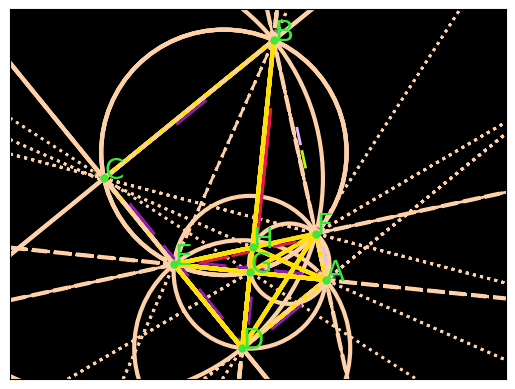

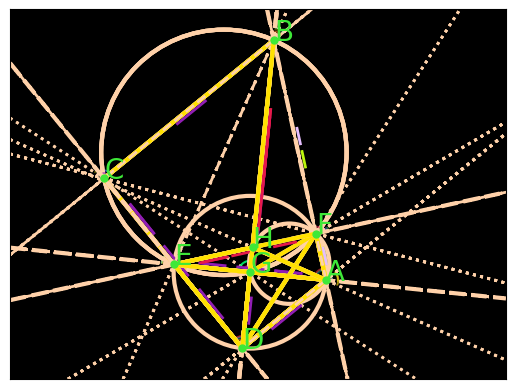

In [27]:
from pathlib import Path
from newclid import GeometricSolverBuilder
from newclid.problem import PredicateConstruction, ProblemSetup
from newclid.jgex.problem_builder import JGEXProblemBuilder
from newclid.jgex.formulation import JGEXFormulation

JGEX_PROBLEM = """C B = segment C B;
D = on_tline D C B C, on_circle D C B;
E = on_line E C D;
A = on_pline A D B C, on_circle A D E;
F = intersection_lt F A B E A B;
G = intersection_ll G B D A E;
H = intersection_ll H B D E F
""".strip().replace('\n', ' ')
goals = [PredicateConstruction.from_str("eqratio D H E H D B E B")]


# Build a JGEX formulation into a ProblemSetup
jgex_problem = JGEXFormulation.from_text(JGEX_PROBLEM)
problem_builder = JGEXProblemBuilder(problem=jgex_problem, rng=0)
problem_setup = problem_builder.build()
problem = ProblemSetup(name=problem_setup.name,
                        points=problem_setup.points,
                        assumptions=problem_setup.assumptions,
                        goals=tuple(goals),
                        )
# Build a solver from the ProblemSetup
solver = GeometricSolverBuilder().build(problem)

# Run deduction + algebraic reasoning
success = solver.run()
print("solved: ", success)

# Print proof (text form)
if success:
    solver.write_all_outputs(Path('out')
                             , jgex_problem=problem_builder.jgex_problem)
    # proof = solver.proof()

Summarize the solution from out/proof.text in human readable steps using ChatGPT:

Because $B,C,E,F$ are concyclic, the angles subtending the same chords are equal; with $A,B,F$ collinear and $C,D,E$ collinear, this gives two matching angles between $\triangle ABE$ and $\triangle DCF$, so $\triangle ABE\sim\triangle DCF$, hence $\dfrac{AE}{BE}=\dfrac{DF}{CF}$.

Because $C,E,F,G$ are concyclic, the same "equal angles on equal arcs" rule gives two matching angles between $\triangle AFG$ and $\triangle DFC$, so $\triangle AFG\sim\triangle DFC$, hence $\dfrac{AF}{DF}=\dfrac{FG}{CF}$. Combining with the previous relation eliminates $CF$ and yields $BE=\dfrac{AE\cdot FG}{AF}$.

Next, since $C,D,E$ are collinear and $B,D,G$ are collinear, and the right-angle/parallels in the construction align the remaining angles, we get $\triangle BCD\sim\triangle EGD$, hence $\dfrac{BD}{CD}=\dfrac{DE}{DG}$. Together with the proportionalities already obtained from $\triangle AFG\sim\triangle DFC$, this rewrites $BD$ in the same scale as $BE$, giving $BD=\dfrac{AD\cdot DF}{AF}$.

Now bring in $H$. Because $A,D,E,F$ are concyclic, equal angles in the same segment give $\triangle ADH\sim\triangle EFD$, so $DH=\dfrac{AD\cdot DF}{EF}$. Also, because $A,F,G,H$ are concyclic, the same cyclic angle rule gives $\triangle AEH\sim\triangle EFG$, so $EH=\dfrac{AE\cdot FG}{EF}$.

Finally,
$$
\frac{BD}{BE}
=\frac{AD\cdot DF/AF}{AE\cdot FG/AF}
=\frac{AD\cdot DF}{AE\cdot FG}
=\frac{AD\cdot DF/EF}{AE\cdot FG/EF}
=\frac{DH}{EH},
$$
so $BE\cdot DH=BD\cdot EH$.

This proof has 65 steps in its proof.text which is about 500 lines. ChatGPT summarized it well, from it we see this doesn't require auxiliary lines other than some trivial connecting existing points. It is also more complex than some of the other methods listed in part 1. In this sense, this method is innovative and reveals a few other similarities of triangles that are not too obvious. 

### 6.2 auxiliary lines
Newclid supports multiple ways of adding auxiliary lines. In the following session we will explore it. First we need to have the G point defined, without that line, even though it is apparently irrelevant, the solver would fail with error message "ProofBuildError: Goal eqratio B D B E D H E H is numerically false.". This shows the solver first makes sure numerically a generated case can verify the goal. The reason this fails without G is because A and B can sit on the opposite side of CD now. In that case though, EA//BD so they would never intersect. This is why by defining G we eliminated an unexpected case defined by JGEX language. Such trap can be subtle. The GeoGebra's plot support would help with such constraints.

solved:  True


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


out1\html\dependency_graph.html


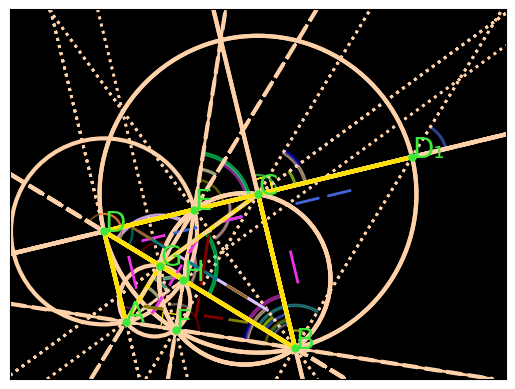

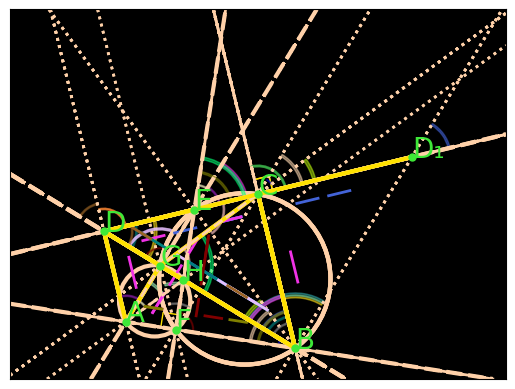

In [26]:
JGEX_PROBLEM = """C B = segment C B;
D = on_tline D C B C, on_circle D C B;
D1 = on_tline D1 C B C, on_circle D1 C B;
E = on_line E C D;
A = on_pline A D B C, on_circle A D E;
F = intersection_lt F A B E A B;
G = intersection_ll G B D A E;
H = intersection_ll H B D E F;
""".strip().replace('\n', ' ')
goals = [PredicateConstruction.from_str("eqratio H D H E D B E B"),
]


jgex_problem = JGEXFormulation.from_text(JGEX_PROBLEM)
problem_builder = JGEXProblemBuilder(problem=jgex_problem, rng=0)
problem_setup = problem_builder.build()
problem = ProblemSetup(name=problem_setup.name,
                        points=problem_setup.points,
                        assumptions=problem_setup.assumptions,
                        goals=tuple(goals)
                        )
solver = GeometricSolverBuilder().build(problem)

success = solver.run()
print("solved: ", success)
if success:
    solver.write_all_outputs(Path('out1'), jgex_problem=problem_builder.jgex_problem)
    proof = solver.proof()

Proof 6.2 can be summarized based on out1/proof.txt by ChatGPT, we see it becomes significantly simpler than the previous proof

>Introduce $D_1$ on the extension of $DC$ such that $CD_1=CD$. Then $C$ is the midpoint of $DD_1$, and since $BC \perp DC$ we also have $BC \perp DD_1$. Hence $BC$ is the perpendicular bisector of $DD_1$, so $BD=BD_1$.
>Newclid then proves two similarities: $\triangle BCG \sim \triangle D_1BE$ and $\triangle BCG \sim \triangle DHE$. From the first, $BD_1:BE=BC:CG$; from the second, $DH:EH=BC:CG$. Therefore $BD_1:BE=DH:EH$, and using $BD_1=BD$ gives $BD:BE=DH:EH$, as desired.

Moreover, beyond Newclid's ratio-chasing, the logic can be shortened: we can show that $\triangle D_1BE \sim \triangle DHE$. That directly yields $BD_1:BE=DH:EH$, and then $BD_1=BD$ finishes the proof in one line. This shortened version is exactly what our proof 1 in part 1 did. So Newclid isn't necessarily putting great efforts to simplify the solution; instead it aims to grow the algebraic reasoning tree till it reach the desired conclusion.


**Reference**

- [AG1] Trinh et al., "Solving olympiad geometry without human demonstrations." Nature (2024). https://www.nature.com/articles/s41586-023-06747-5
- [AG1-BLOG] Trinh & Luong, "AlphaGeometry: An Olympiad-level AI system for geometry." DeepMind blog (Jan 17, 2024). https://deepmind.google/discover/blog/alphageometry-an-olympiad-level-ai-system-for-geometry/
- [AG2] Chervonyi et al., "Gold-medalist Performance in Solving Olympiad Geometry with AlphaGeometry2." arXiv:2502.03544. https://dblp.org/rec/journals/corr/abs-2502-03544
- [HAG] Duan et al., "Gold-Medal-Level Olympiad Geometry Solving with Efficient Heuristic Auxiliary Constructions." arXiv:2512.00097. https://huggingface.co/papers/2512.00097
- [GEN] Zhu et al., "GenesisGeo: Technical Report." arXiv:2509.21896. https://huggingface.co/papers/2509.21896
- [NC] Sicca et al., "Newclid: A User-Friendly Replacement for AlphaGeometry." arXiv:2411.11938. https://notesum.ai/share/arxiv_papers/public/2024-11-20/2411.11938v1
- [AREA] Janicic, Narboux, Quaresma, "The Area Method: a Recapitulation." J. Autom. Reason. (2012). https://research.matf.bg.ac.rs/handle/123456789/510
- [COQ-AM] Narboux, "Formalization of the Area Method in the Coq proof assistant." https://www.irif.fr/~narboux/area_method.html
- [FA] Baeta & Quaresma, "The full angle method on the OpenGeoProver." ThEdu 2013. https://old.cisuc.uc.pt/publication/show/3494
- [VDP] Ye, Chou, Gao, "Visually Dynamic Presentation of Proofs in Plane Geometry (Part 1)." J. Autom. Reason. (2010). https://dblp.org/rec/journals/jar/YeCG10a
- [GGB] Botana et al., "Automated Theorem Proving in GeoGebra: Current Achievements." J. Autom. Reason. (2015). https://research.matf.bg.ac.rs/handle/123456789/503
- [EO] Li et al., "Euclid-Omni: A Unified Neuro-Symbolic Framework for Geometry Problem Solving." OpenReview (ICLR 2026 submission). https://openreview.net/forum?id=1GQv7jhmtV
- [LG] LeanGeo benchmark page. https://www.alphaxiv.org/benchmarks/university-of-toronto/leangeo
- [SURVEY] Chou et al., "Automated geometric reasoning: Dixon resultants, Grobner bases, and characteristic sets." ADG 1996. https://link.springer.com/chapter/10.1007/BFb0022716
- [WU] Chou & Gao, "Ritt-Wu's decomposition algorithm and geometry theorem proving." CADE 1990. https://link.springer.com/chapter/10.1007/3-540-52885-7_89
